# Simple EDA for Data Collected from Reddit <br>(Posts & Comments)

## Authors:                     
##   * Maxim Subotin - 207695479  
##   * Amiel Cohen - 315196311  

---

---

### Overview:

We have performed a basic EDA on some 8,000 posts and comments that we have collected from Reddit from the following sub-reddits: 'conspiracy', 'worldnews', 'politics', 'IsraelPalestine', 'AskReddit'<br>

The posts and comments were collected such that each of them **must include at least one** of the following keywords:<br>'jew', 'jews', 'zionist', 'zionism', 'zion', 'mosad', 'zio', 'kike', 'heeb', 
            'yid', 'isreal' ,'holocaust', 'holohoax', 'cabal', <br>'genocide', 'zog',
            'occupied', 'occupation', 'nazi', 'jewish', 'zion', 'idf', 'palestine'.<br>

In this notebook we explore this collected data, perform some modifications to it like removing duplicaions, calculating the amount of keywords in each post/comment, cleaning the posts/comments from non-alpha-numeric characters, identify most common words, perform visualizations of the data, tokenization and normalization using TF-IDF.

### Some Imports

In [10]:
import pandas as pd
from collections import Counter
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
import seaborn as sns

# Download and get the list of English stop words
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /Users/max/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Importing the Data

In [11]:
redditDataFrame = pd.read_csv('reddit_data.csv')
redditDataFrame.head(3)

,_id,ID,Username,Message,Likes,Timestamp,Link
0,67ead24e2af5a847d6265aeb,1jo7pnk,Different-Article-71,IDF tells Gazans to flee entire Rafah area in ...,21,31-03-2025 16:44:18,https://www.timesofisrael.com/idf-tells-gazans...
1,67ead24e2af5a847d6265aec,mkpuy6v,fury420,>The evacuation area covers a large swath of l...,1,31-03-2025 17:28:02,https://www.reddit.com/r/worldnews/comments/1j...
2,67ead24e2af5a847d6265aed,1jo8fjw,Pleasant-Positive-16,“Israel: The Most Incompetent Genociders in Hi...,8,31-03-2025 17:13:24,https://www.reddit.com/r/IsraelPalestine/comme...


In [12]:
print(f'The original shape of the dataframe is: {redditDataFrame.shape}')

The original shape of the dataframe is: (8322, 7)


Dropping the he _id column since it’s not needed (its the id of the objects from the MongoDB database).
Convert the Timestamp column from string format into a datetime object.
Identify any nulls or anomalies.

In [13]:
redditDataFrame.drop('_id', axis=1, inplace=True)
redditDataFrame['Timestamp'] = pd.to_datetime(redditDataFrame['Timestamp'], format='%d-%m-%Y %H:%M:%S')
print(f'Null Values Per Column:\n\n{redditDataFrame.isnull().sum()}')

Null Values Per Column:

ID             0
Username     132
Message        0
Likes          0
Timestamp      0
Link           0
dtype: int64


Found that 132 rows have null 'Username' values, thats why i remove them here.

In [14]:
redditDataFrame = redditDataFrame.dropna(subset=['Username'])

Checking for duplicate rows and removeing them. Removing rows if they contain the same ID and Message because this approach seems the most logical.

In [15]:
num_duplicates = redditDataFrame.duplicated(subset=['ID', 'Message']).sum()
redditDataFrame = redditDataFrame.drop_duplicates(subset=['ID', 'Message'])

In [16]:
print(f'Number of rows dropped: {num_duplicates}')
print(f'The new shape of the dataset is: {redditDataFrame.shape}')

Number of rows dropped: 54
The new shape of the dataset is: (8136, 6)


Look at numerical columns using descriptive stats.


In [17]:
print(redditDataFrame.describe())
print(f'\n\nNumber of Unique Users: {redditDataFrame["Username"].nunique()}')

             Likes                      Timestamp
count  8136.000000                           8136
mean      8.914823  2025-03-18 08:28:44.442969344
min    -142.000000            2025-02-26 22:24:22
25%       1.000000  2025-03-11 02:13:08.750000128
50%       2.000000            2025-03-19 20:06:45
75%       6.000000  2025-03-25 23:15:55.249999872
max    6490.000000            2025-03-31 19:38:44
std     117.276646                            NaN


Number of Unique Users: 1911


Break down the Message content into individual words.
Count the frequency of each word.

In [18]:
# Convert messages to lowercase and tokenize
messages = redditDataFrame['Message'].astype(str).str.lower()
all_words = ' '.join(messages).split()

# Get frequency distribution of words
word_freq = Counter(all_words)
print('Top 20 words:\n')
for word, count in word_freq.most_common(20):
    print(f'"{word}" - {count}')

Top 20 words:

"the" - 52698
"to" - 28904
"and" - 28845
"of" - 26274
"a" - 20674
"in" - 16463
"is" - 16069
"that" - 15106
"you" - 9084
"for" - 8988
"it" - 8886
"they" - 8815
"are" - 8412
"not" - 8155
"i" - 7745
"israel" - 6855
"as" - 6731
"have" - 6433
"with" - 6301
"this" - 6226


As expected most of the most common words will be stop words (the, to, and , a, etc.).
Removing stop words and checking again

In [19]:
# Helper function for removing stop words form a givne text
def tokenize_remove_stopwords(text):
    words = text.lower().split()
    filtered_words = [word for word in words if word not in stop_words]
    return filtered_words

In [20]:
# Create a column with filtered words for each message (optional, for further analysis)
redditDataFrame['Message'] = redditDataFrame['Message'].astype(str).apply(tokenize_remove_stopwords)

# Count frequency of words (after removing stop words)
from collections import Counter
all_filtered_words = [word for words in redditDataFrame['Message'] for word in words]
word_freq = Counter(all_filtered_words)

print('Top 20 words (after stop words removal):\n')
for word, count in word_freq.most_common(20):
    print(f'"{word}" - {count}')

Top 20 words (after stop words removal):

"israel" - 6855
"jews" - 4676
"people" - 4117
"would" - 3453
"jewish" - 3070
"palestinians" - 2936
"like" - 2733
"palestinian" - 2632
"hamas" - 2507
"israeli" - 2351
"even" - 2326
"one" - 2079
"think" - 2070
"war" - 1880
"-" - 1867
"arab" - 1866
"state" - 1837
"land" - 1778
"also" - 1662
"many" - 1584


It seems that might be some non-alpha-numeric characters in the messages we gathered from reddit, there for we will need to do some more cleaning to the text.

For example lets look at how many non-alpha-numeric characters is there in the messages

In [21]:
def count_special_chars(text):
    return len(re.findall(r'[^a-zA-Z0-9\s]', text))

specialCharacterCountList = redditDataFrame['Message'].astype(str).apply(count_special_chars)

print(specialCharacterCountList.describe())

count     8136.000000
mean       252.901794
std        353.383749
min          4.000000
25%         66.000000
50%        139.000000
75%        300.000000
max      11644.000000
Name: Message, dtype: float64


We can see that on average there are about 17 non-alpha-numeric characters in a single message.
At this stage we will replace these characters in-place with an empty string like ' '.

In [22]:
# Remove special characters but keep spaces
def clean_text(text): 
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = ' '.join(text.split())

    return text

redditDataFrame['Message'] = redditDataFrame['Message'].astype(str).apply(clean_text)
redditDataFrame.head(3)

,ID,Username,Message,Likes,Timestamp,Link
0,1jo7pnk,Different-Article-71,idf tells gazans flee entire rafah area larges...,21,2025-03-31 16:44:18,https://www.timesofisrael.com/idf-tells-gazans...
1,mkpuy6v,fury420,the evacuation area covers large swath land ra...,1,2025-03-31 17:28:02,https://www.reddit.com/r/worldnews/comments/1j...
2,1jo8fjw,Pleasant-Positive-16,israel incompetent genociders history listen u...,8,2025-03-31 17:13:24,https://www.reddit.com/r/IsraelPalestine/comme...


But its worth noting that since its data from reddit we might want to first remove common strings like /u and /r and such before we remove the rest of the special characters.

---

### Looking at the Special Antisemitic Keywords Thhat Were Used in the collection of the Data

Since the data is guaranteed to contain at least one keyword, create a flag that checks for their presence in each text and save this counter as a new column

In [23]:
keywords = ['jew', 'jews', 'zionist', 'zionism', 'zion', 'mosad', 'zio', 'kike', 'heeb', 'yid', 'israel', 'holocaust', 'holohoax', 'cabal', 'genocide', 'zog', 'occupied', 'occupation', 'nazi', 'jewish', 'zion', 'idf', 'palestine']

def count_keywords(text):
    return sum(text.lower().count(word) for word in keywords)

redditDataFrame['KeywordCount'] = redditDataFrame['Message'].astype(str).apply(count_keywords)

In [24]:
redditDataFrame.head(3)

,ID,Username,Message,Likes,Timestamp,Link,KeywordCount
0,1jo7pnk,Different-Article-71,idf tells gazans flee entire rafah area larges...,21,2025-03-31 16:44:18,https://www.timesofisrael.com/idf-tells-gazans...,1
1,mkpuy6v,fury420,the evacuation area covers large swath land ra...,1,2025-03-31 17:28:02,https://www.reddit.com/r/worldnews/comments/1j...,1
2,1jo8fjw,Pleasant-Positive-16,israel incompetent genociders history listen u...,8,2025-03-31 17:13:24,https://www.reddit.com/r/IsraelPalestine/comme...,32


---

### Visualizations of the Data

Visualize the distribution of the Likes column

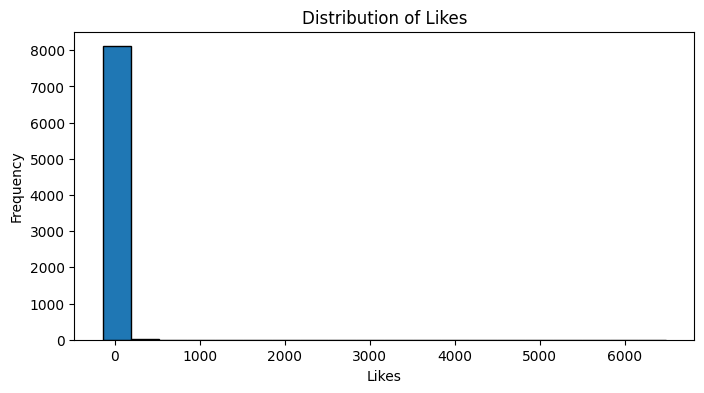

In [25]:
plt.figure(figsize=(8, 4))
plt.hist(redditDataFrame['Likes'], bins=20, edgecolor='black')
plt.xlabel('Likes')
plt.ylabel('Frequency')
plt.title('Distribution of Likes')
plt.show()

Plot the number of posts/comments over time

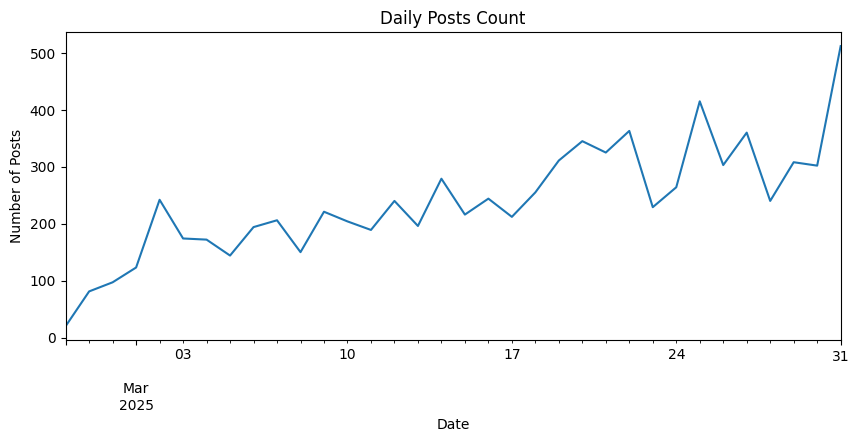

In [26]:
redditDataFrame.set_index('Timestamp').resample('D').size().plot(figsize=(10, 4))
plt.xlabel('Date')
plt.ylabel('Number of Posts')
plt.title('Daily Posts Count')
plt.show()

Analyzing message length distrobution.

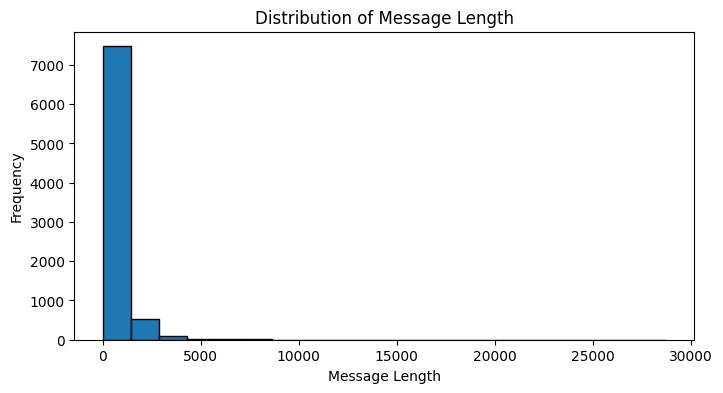

In [27]:
messageLengthList = redditDataFrame['Message'].apply(lambda x: len(str(x)))
plt.figure(figsize=(8, 4))
plt.hist(messageLengthList, bins=20, edgecolor='black')
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.title('Distribution of Message Length')
plt.show()

Now lets look are some visualizations that are related to the textual data that we have, for example lets look are a word cloud of the most common words in the dataset.

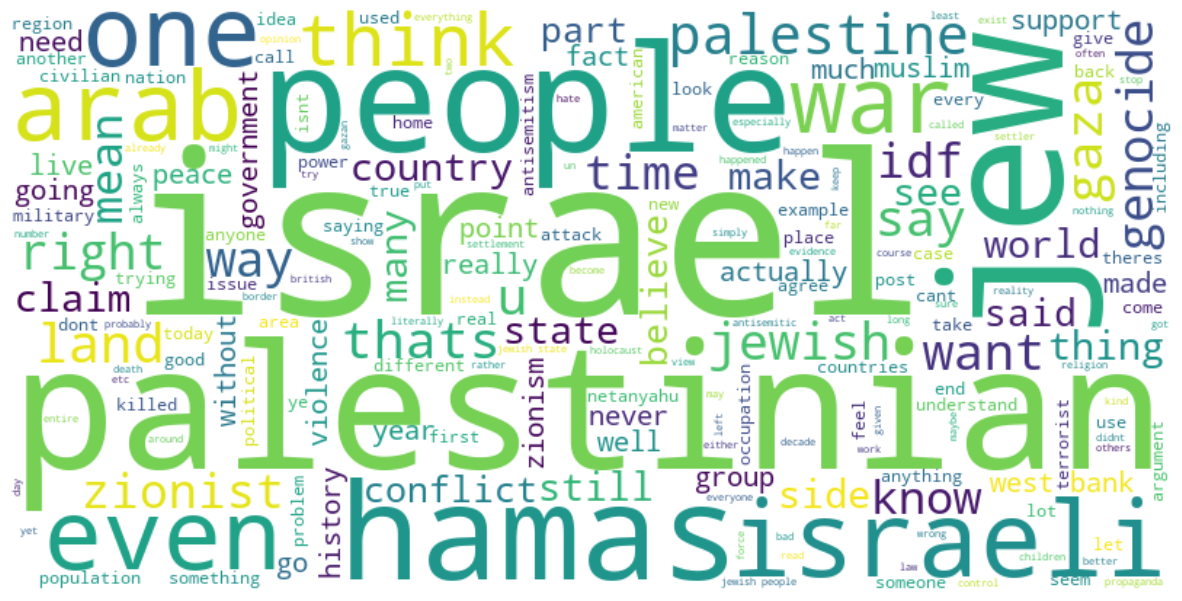

In [28]:
text = ' '.join(redditDataFrame['Message'].astype(str)) # Combine all messages into one large text
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text) # Generate a word cloud

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Another thing that we can do is to analyze the sentiment of messages to see their emotional tone using the TextBlob library in Python.

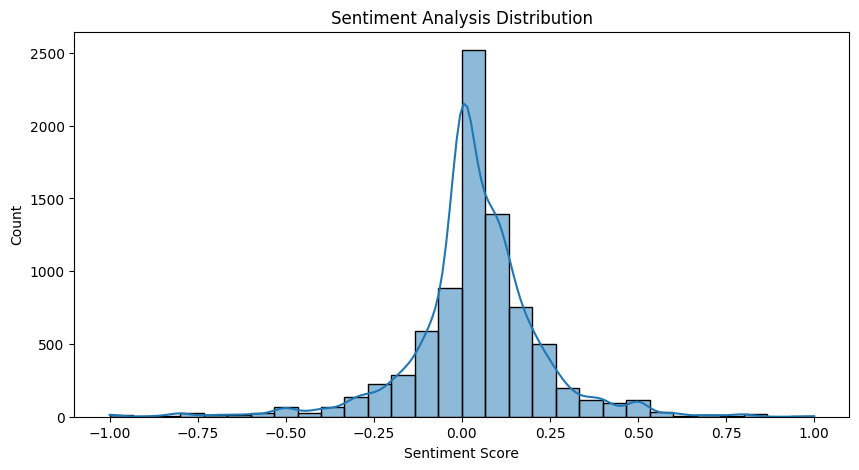

In [29]:
# Get sentiment polarity (negative < 0, neutral = 0, positive > 0)
sentimentList = redditDataFrame['Message'].astype(str).apply(lambda x: TextBlob(x).sentiment.polarity)

plt.figure(figsize=(10, 5))
sns.histplot(sentimentList, bins=30, kde=True)
plt.title('Sentiment Analysis Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Count')
plt.show()

---

### This is the data we are working with after the above manipulations:

In [30]:
redditDataFrame.head(3)

,ID,Username,Message,Likes,Timestamp,Link,KeywordCount
0,1jo7pnk,Different-Article-71,idf tells gazans flee entire rafah area larges...,21,2025-03-31 16:44:18,https://www.timesofisrael.com/idf-tells-gazans...,1
1,mkpuy6v,fury420,the evacuation area covers large swath land ra...,1,2025-03-31 17:28:02,https://www.reddit.com/r/worldnews/comments/1j...,1
2,1jo8fjw,Pleasant-Positive-16,israel incompetent genociders history listen u...,8,2025-03-31 17:13:24,https://www.reddit.com/r/IsraelPalestine/comme...,32


---

### TF-IDF Data Vectorization and Normalization

A common approach to vectorizing text based data is using TF-IDF which converts text into numerical vectors by giving higher importance to words that apper frequently in a given text and reducing importance of common words across all texts.

In [31]:
vectorizer = TfidfVectorizer(max_features=500) #limit to 500 most important words (can be adjusted later)
tfidf_matrix = vectorizer.fit_transform(redditDataFrame['Message'])

print(tfidf_matrix)

  (0, 201)	0.3221475098964952
  (0, 167)	0.4750169777914638
  (0, 131)	0.3985552064487092
  (0, 37)	0.44233000270294986
  (0, 402)	0.3503537498670539
  (0, 155)	0.43969309609417406
  (1, 201)	0.36141281270158576
  (1, 37)	0.4962438805457064
  (1, 437)	0.4596795227847804
  (1, 237)	0.32314624244575535
  (1, 152)	0.4417457413493297
  (1, 436)	0.3350443734214081
  (2, 201)	0.0410296305913364
  (2, 436)	0.07607227187341953
  (2, 218)	0.2130608832394129
  (2, 191)	0.08699085200912554
  (2, 461)	0.40608907133501354
  (2, 181)	0.051014296712198565
  (2, 169)	0.23559760552385947
  (2, 135)	0.15421131206400432
  (2, 81)	0.17049647646401636
  (2, 166)	0.1126206553556031
  (2, 112)	0.05465414940104145
  (2, 494)	0.05313120142987091
  (2, 348)	0.31523994575600983
  :	:
  (8134, 129)	0.14429503903624707
  (8134, 280)	0.16098032649088231
  (8134, 463)	0.11754779640222422
  (8134, 495)	0.14278452854684748
  (8134, 199)	0.14175535431546066
  (8134, 157)	0.13003358366571682
  (8134, 342)	0.143398814686

After creating vectors from the text messages we can perform some normalization on the vectors to help the models learn better on this data.

In [32]:
normalizer = Normalizer(norm='l2') #ernsures each row has unit norm
normalized_tfidf = normalizer.fit_transform(tfidf_matrix)

print(normalized_tfidf[:5]) #printing first 5 normalized vectors

  (0, 201)	0.3221475098964952
  (0, 167)	0.4750169777914638
  (0, 131)	0.3985552064487092
  (0, 37)	0.44233000270294986
  (0, 402)	0.3503537498670539
  (0, 155)	0.43969309609417406
  (1, 201)	0.36141281270158576
  (1, 37)	0.4962438805457064
  (1, 437)	0.4596795227847804
  (1, 237)	0.32314624244575535
  (1, 152)	0.4417457413493297
  (1, 436)	0.3350443734214081
  (2, 201)	0.04102963059133641
  (2, 436)	0.07607227187341954
  (2, 218)	0.21306088323941294
  (2, 191)	0.08699085200912555
  (2, 461)	0.4060890713350136
  (2, 181)	0.05101429671219857
  (2, 169)	0.2355976055238595
  (2, 135)	0.15421131206400435
  (2, 81)	0.1704964764640164
  (2, 166)	0.11262065535560312
  (2, 112)	0.054654149401041456
  (2, 494)	0.05313120142987092
  (2, 348)	0.3152399457560099
  :	:
  (3, 67)	0.13772851027041744
  (3, 344)	0.3975690115147915
  (3, 424)	0.11183835047209992
  (3, 288)	0.15331370692057034
  (3, 87)	0.14548470576870182
  (3, 313)	0.12549048730705167
  (3, 255)	0.14642878028753475
  (3, 380)	0.151455

In [33]:
tfidf_df = pd.DataFrame(normalized_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df.head(3)

,100,1948,7th,able,accept,accepted,act,action,actions,actual,...,wrong,year,years,yes,yet,you,youre,zionism,zionist,zionists
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.113867,...,0.0,0.059278,0.0,0.049623,0.053131,0.0,0.0,0.0,0.0,0.0


---

### Next Steps:

* Our next steps should be to perform some lemmatization and stemming on the texts to reduce the amount of duplications.
* Then perform some spelling mistakes correction using tools like TextBlob.
* Find more redundunt information in the texts that we can clean like the /u and /r we mentioned before.
* Collect more data, collect benign data and label the data we collect.
* Identify key features in the data we collect from Reddit other than the texts them selves, perhaps the KeywordCount feature will be good to have to improve the models accuracy.